<a href="https://colab.research.google.com/github/rizqyjoe/Facial_Expression_Recognition_CNN_VGG16/blob/main/Scratch/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import keras
from keras.models import Sequential
from keras.layers import *
from keras_preprocessing.image import ImageDataGenerator

import zipfile 

import cv2
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop,Adam
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

Load Data

In [38]:
path = '/content/drive/MyDrive/Dataset/fer2013 dataset/'
os.listdir(path)

['example_submission.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'test.csv',
 'train.csv',
 'dataset',
 '.ipynb_checkpoints',
 'fer2013']

In [39]:
data = pd.read_csv(path+'icml_face_data.csv')
data.columns = ['emotion', 'Usage', 'pixels']      
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [40]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [41]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [42]:
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [43]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Helping functions

In [44]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

def vis_training(hlist, start=1):
    
    loss = np.concatenate([h.history['loss'] for h in hlist])
    val_loss = np.concatenate([h.history['val_loss'] for h in hlist])
    acc = np.concatenate([h.history['accuracy'] for h in hlist])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in hlist])
    
    epoch_range = range(1,len(loss)+1)

    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

Prepare the data

In [45]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [46]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])

print(full_train_images.shape)
print(full_train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


In [47]:
train_images, valid_images, train_labels, valid_labels =\
    train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

print(train_images.shape)
print(valid_images.shape)
print(train_labels.shape)
print(valid_labels.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)
(22967,)
(5742,)


Display Sample of Images

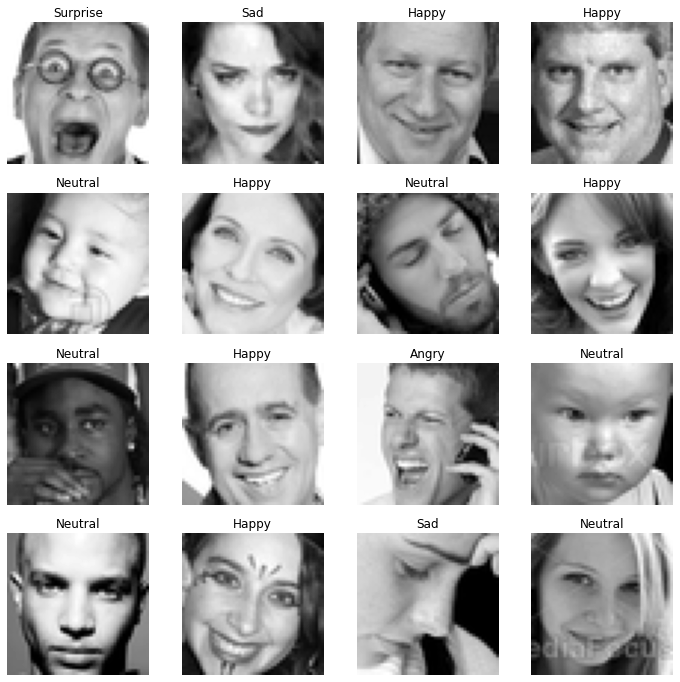

In [48]:
N_train = train_labels.shape[0]

sel = np.random.choice(range(N_train), replace=False, size=16)

X_sel = train_images[sel, :, :, :]
y_sel = train_labels[sel]

plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_sel[i,:,:,0], cmap='binary_r')
    plt.title(emotions[y_sel[i]])
    plt.axis('off')
plt.show()

Model

In [ ]:
'''cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48,48,1)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())'''


In [52]:
%%time 

cnn = Sequential()

cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(48,48,1)))
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())

cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())

cnn.add(Flatten())

cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(7, activation='softmax'))

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 24, 128)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 256)      

In [53]:
opt = keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

Training 

In [54]:
h1 = cnn.fit(train_images, 
               train_labels, 
               batch_size=256, 
               epochs=30, 
               verbose=1, 
               validation_data = (valid_images, valid_labels)) 

Epoch 1/30
90/90 [==============================] - 31s 326ms/step - loss: 2.1259 - accuracy: 0.2002 - val_loss: 1.8227 - val_accuracy: 0.2567
Epoch 2/30
90/90 [==============================] - 29s 325ms/step - loss: 1.8327 - accuracy: 0.2249 - val_loss: 1.8425 - val_accuracy: 0.2193
Epoch 3/30
90/90 [==============================] - 28s 317ms/step - loss: 1.8127 - accuracy: 0.2462 - val_loss: 1.8328 - val_accuracy: 0.1621
Epoch 4/30
90/90 [==============================] - 29s 319ms/step - loss: 1.7762 - accuracy: 0.2753 - val_loss: 1.8411 - val_accuracy: 0.1656
Epoch 5/30
90/90 [==============================] - 29s 320ms/step - loss: 1.6882 - accuracy: 0.3233 - val_loss: 1.7774 - val_accuracy: 0.2379
Epoch 6/30
90/90 [==============================] - 29s 319ms/step - loss: 1.5647 - accuracy: 0.3755 - val_loss: 1.6417 - val_accuracy: 0.3539
Epoch 7/30
90/90 [==============================] - 29s 318ms/step - loss: 1.4638 - accuracy: 0.4199 - val_loss: 1.5105 - val_accuracy: 0.4002

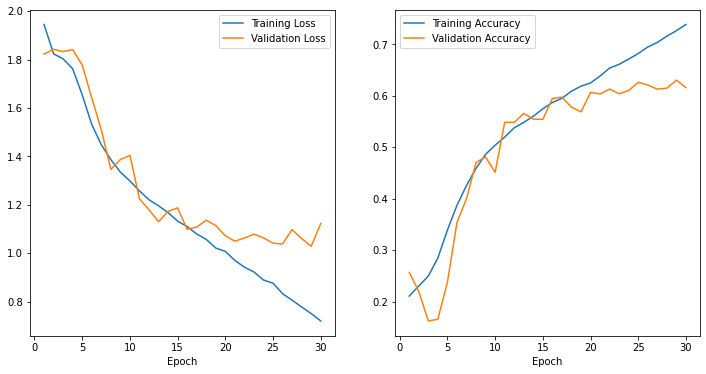

In [55]:
vis_training([h1])

Save Model

In [ ]:
model.save('final_model.h5')

Evaluating the model

In [56]:
test_prob = cnn.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == test_labels)

print(test_accuracy)

0.6173028698801895


Confusion matrix

In [57]:
conf_mat = confusion_matrix(test_labels, test_pred)

pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
Angry,528,35,62,73,199,12,49
Disgust,25,64,8,1,11,2,0
Fear,131,18,349,81,319,63,63
Happy,29,1,25,1594,65,17,43
Sad,135,16,95,123,742,6,130
Surprise,27,3,104,82,21,567,27
Neutral,95,6,37,192,309,7,587


In [63]:
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

TypeError: ignored

Classification report

In [59]:
print(classification_report(test_labels, test_pred, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       0.54      0.55      0.55       958
     Disgust       0.45      0.58      0.50       111
        Fear       0.51      0.34      0.41      1024
       Happy       0.74      0.90      0.81      1774
         Sad       0.45      0.60      0.51      1247
    Surprise       0.84      0.68      0.75       831
     Neutral       0.65      0.48      0.55      1233

    accuracy                           0.62      7178
   macro avg       0.60      0.59      0.58      7178
weighted avg       0.62      0.62      0.61      7178

